In [1]:
#!pip install transformers datasets torch soundfile torchaudio
#!pip install whisper

In [1]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch import nn
from transformers import WhisperProcessor, WhisperModel, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict
import soundfile as sf
import numpy as np
from sklearn.model_selection import train_test_split
import whisper_at as wat
from tqdm import tqdm
#import whisper

In [3]:
video_tags = pd.read_csv('C:/Users/ahi81/Downloads/processed_targets_output.csv')
video_tags.head()

,audio_file_name,interval_start,interval_end,target,next_target
0,15 Minutes of Katt Williams.mp3,0,10,0,0
1,15 Minutes of Katt Williams.mp3,10,20,0,0
2,15 Minutes of Katt Williams.mp3,20,30,0,0
3,15 Minutes of Katt Williams.mp3,30,40,0,0
4,15 Minutes of Katt Williams.mp3,40,50,0,0


In [4]:
video_tags['audio_file_name'].unique

<bound method Series.unique of 0                        15 Minutes of Katt Williams.mp3
1                        15 Minutes of Katt Williams.mp3
2                        15 Minutes of Katt Williams.mp3
3                        15 Minutes of Katt Williams.mp3
4                        15 Minutes of Katt Williams.mp3
                              ...                       
6857    ＂Russians＂ ｜  Russell Peters - Almost Famous.mp3
6858    ＂Russians＂ ｜  Russell Peters - Almost Famous.mp3
6859    ＂Russians＂ ｜  Russell Peters - Almost Famous.mp3
6860    ＂Russians＂ ｜  Russell Peters - Almost Famous.mp3
6861    ＂Russians＂ ｜  Russell Peters - Almost Famous.mp3
Name: audio_file_name, Length: 6862, dtype: object>

In [5]:

# Path to the folder containing the extracted audio files
audio_folder = 'C:/Users/ahi81/Downloads/MP3 Audio'

# Generate full file paths
video_tags["Audio File Path"] = video_tags["audio_file_name"].apply(lambda title: os.path.join(audio_folder, title))

# Check if files exist
video_tags["File Exists"] = video_tags["Audio File Path"].apply(lambda path: os.path.exists(path))


# Print a summary of missing files
missing_files = video_tags[~video_tags["File Exists"]]
if not missing_files.empty:
    print(f"{len(missing_files)} files were not found:")
    print(missing_files)
else:
    print("All files matched successfully!")

# Filter out rows with missing files
video_tags_filtered = video_tags[video_tags["File Exists"]].reset_index(drop=True)
print(f"Number of valid files: {len(video_tags_filtered)}")


220 files were not found:
                                        audio_file_name  interval_start  \
1179        Dave Chappelle Stand-Up Monologue - SNL.mp3               0   
1180        Dave Chappelle Stand-Up Monologue - SNL.mp3              10   
1181        Dave Chappelle Stand-Up Monologue - SNL.mp3              20   
1182        Dave Chappelle Stand-Up Monologue - SNL.mp3              30   
1183        Dave Chappelle Stand-Up Monologue - SNL.mp3              40   
...                                                 ...             ...   
5155  Rove McManus - Set List： Stand-Up Without a Ne...             390   
5156  Rove McManus - Set List： Stand-Up Without a Ne...             400   
5157  Rove McManus - Set List： Stand-Up Without a Ne...             410   
5158  Rove McManus - Set List： Stand-Up Without a Ne...             420   
5159  Rove McManus - Set List： Stand-Up Without a Ne...             430   

      interval_end  target  next_target  \
1179            10       0    

In [6]:
# Filter out rows where 'File Exists' is False
video_tags_filtered = video_tags[video_tags["File Exists"]].reset_index(drop=True)

# Print the number of valid files
print(f"Number of valid files: {len(video_tags_filtered)}")


Number of valid files: 6642


In [8]:
import xlsxwriter

In [ ]:
# import gc
# gc.collect()  # Garbage collect to free memory

Fitting 3 folds for each of 180 candidates, totalling 540 fits


C:\Users\ahi81\Downloads\anaconda\New folder\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Parameters: {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


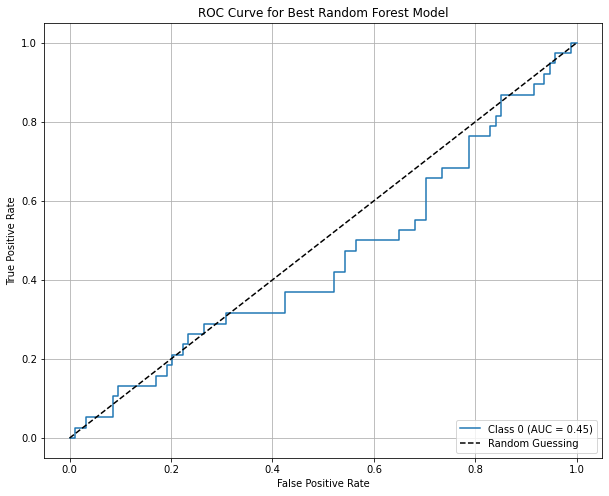

Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        94
           1       0.00      0.00      0.00        38

    accuracy                           0.71       132
   macro avg       0.36      0.50      0.42       132
weighted avg       0.51      0.71      0.59       132



C:\Users\ahi81\Downloads\anaconda\New folder\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahi81\Downloads\anaconda\New folder\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ahi81\Downloads\anaconda\New folder\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [9]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np

# Load feature vectors and labels from the processed file
input_file = 'processed_audio_features_subset_attention.xlsx'  # Update with your file path
df = pd.read_excel(input_file)

# Separate features and labels
X = df.iloc[:, :-1].values  # All columns except the last are features
y = df['label'].values      # The last column is the label

# Convert labels to binary format for ROC curve
lb = LabelBinarizer()
y_binary = lb.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Define parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 4, 6, 8,12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Best parameters and model
print(f"Best Parameters: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

# Evaluate the best model on the test set
y_proba = best_rf.predict_proba(X_test)

# Compute ROC curve and AUC for each class
n_classes = y_binary.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i],
        label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})'
    )

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc="lower right")
plt.grid()
plt.show()

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
